In [1]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

# 200
i = 200
fn = '/datax/users/bryanb/data/split_files/4194304_%04d.fil' % i
fil = Waterfall(fn)

In [2]:
fil.header

{'az_start': 0.0,
 'data_type': 1,
 'fch1': 6095.214842353016,
 'foff': -2.7939677238464355e-06,
 'machine_id': 20,
 'nbits': 32,
 'nchans': 4194304,
 'nifs': 1,
 'source_name': 'HIP43223',
 'src_dej': <Angle 18.7477 deg>,
 'src_raj': <Angle 8.80492 hourangle>,
 'telescope_id': 6,
 'tsamp': 18.253611008,
 'tstart': 58090.468206018515,
 'za_start': 0.0}

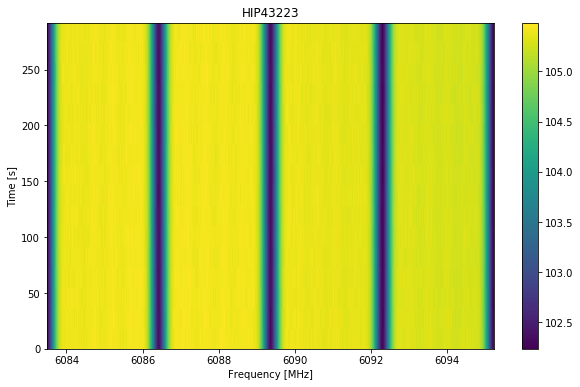

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
fil.plot_waterfall()

In [16]:
def normalize(data, axis=0):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    data = np.nan_to_num((data-mean)/std)
    return data

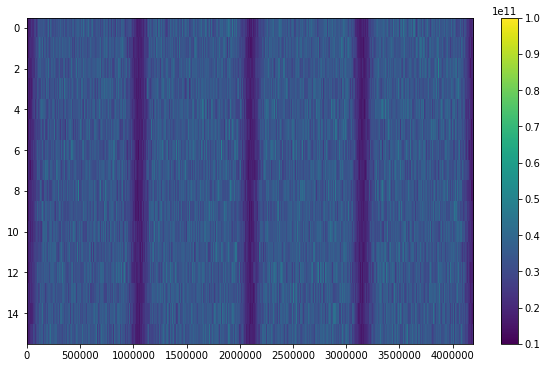

In [5]:
plt.figure(figsize=(10,6))
plt.imshow(np.squeeze(fil.data), aspect='auto', vmin=1e10, vmax=1e11)
plt.colorbar()

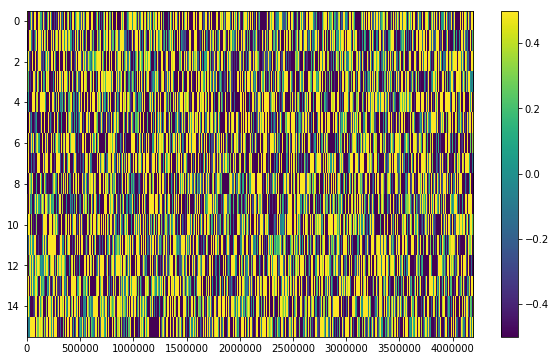

In [17]:
plt.figure(figsize=(10,6))
fil_data = normalize(np.squeeze(fil.data),axis=0)
plt.imshow(fil_data, aspect='auto', vmin=-0.5, vmax=0.5)
plt.colorbar()

In [7]:
fil.data

array([[[1.8482960e+10, 1.7536498e+10, 1.5259583e+10, ...,
         1.6622680e+10, 1.6724848e+10, 1.8161705e+10]],

       [[1.6916804e+10, 1.7282275e+10, 1.8433333e+10, ...,
         1.5167884e+10, 1.5181833e+10, 1.8267001e+10]],

       [[1.9275289e+10, 1.5038574e+10, 1.7313612e+10, ...,
         1.6455030e+10, 1.7967718e+10, 1.5030796e+10]],

       ...,

       [[1.6603161e+10, 1.7249767e+10, 1.5900834e+10, ...,
         1.7909746e+10, 1.6225068e+10, 2.1361355e+10]],

       [[1.4180111e+10, 1.6314629e+10, 1.6197606e+10, ...,
         2.2633763e+10, 1.7841193e+10, 1.9800984e+10]],

       [[1.8233534e+10, 1.7928247e+10, 1.5253342e+10, ...,
         1.5970689e+10, 1.4569475e+10, 1.8988849e+10]]], dtype=float32)

In [8]:
processed = preprocess(np.squeeze(fil.data))

In [9]:
max(map(max,processed))

1347.9856

In [10]:
min(map(min,processed))

-0.3546622

In [11]:
len(processed[0])

4194304

In [12]:
x = [0,1,2]
y = x
def f(x,y):
    return x + y
np.fromfunction(f, (10,10))

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.],
       [ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.],
       [ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18.]])

In [13]:
def freq(t, freq_start, drift_rate):
    '''
    Calculate arrival times for all channels
    '''
    return freq_start + drift_rate * t

def time(freq, t_start, drift_rate):
    return t_start + drift_rate * freq

In [14]:
t = np.arange(16)
f = np.arange(0,1000)
f0 = freq(t, 500, 2)
f0

array([500, 502, 504, 506, 508, 510, 512, 514, 516, 518, 520, 522, 524,
       526, 528, 530])

In [15]:
f0 = f0[:,np.newaxis]
f0

array([[500],
       [502],
       [504],
       [506],
       [508],
       [510],
       [512],
       [514],
       [516],
       [518],
       [520],
       [522],
       [524],
       [526],
       [528],
       [530]])

In [16]:
f - f0

array([[-500, -499, -498, ...,  497,  498,  499],
       [-502, -501, -500, ...,  495,  496,  497],
       [-504, -503, -502, ...,  493,  494,  495],
       ...,
       [-526, -525, -524, ...,  471,  472,  473],
       [-528, -527, -526, ...,  469,  470,  471],
       [-530, -529, -528, ...,  467,  468,  469]])

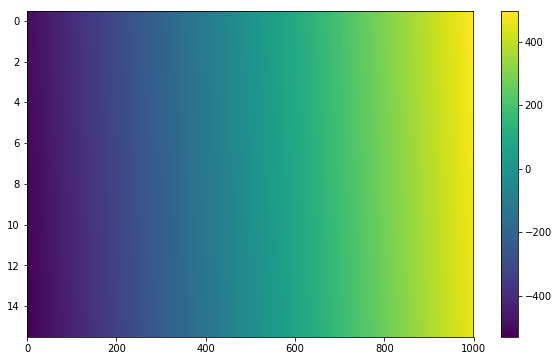

In [17]:
plt.figure(figsize=(10,6))
plt.imshow((f-f0), aspect='auto', interpolation='None')
plt.colorbar()
# plt.imshow(np.exp(-0.5 * (f - f0) ** 2 / 100 ** 2.))

In [18]:
# try his stuff
import numpy as np
import pylab as plt
from scipy import ndimage
def get_ts(t_start, nus, DM):
    '''
    Calculate arrival times for all channels
    '''
    return 4.15*DM*(nus**(-2)-nus[-1]**(-2)) + t_start
def modulate(nus, bp=None):
    '''
    Modulate over frequencies, here's just an example, using gaussian envelop 
    try to mimick whatever variations/patterns seen in data'''
    length = nus.size
    df = nus[1] - nus[0]
    fpeak = np.random.uniform(nus[500], nus[-500], size=1)
    fwidth = np.random.uniform(length/20, length/5, size=1)*df
    print(fpeak, fwidth)
    if bp is None:
        return np.exp(-0.5 * (nus - fpeak) ** 2 / fwidth ** 2.)
    else:
        bpmod = np.where(bp>np.mean(bp), 1., bp/np.mean(bp))
        return np.exp(-0.5 * (nus - fpeak) ** 2 / fwidth ** 2.)*bpmod
    
t = np.arange(0, 200., 0.3)
nu = np.arange(4., 8., 0.0014648) #assume you max pooled factor of 8
t_0 = np.random.uniform(-20., 150., size=1) 
modulation = modulate(nu)
amp = np.random.uniform(1., 4.) * modulation[:, np.newaxis]
#Note the values  1. is kind of arbitrary here, depending on how you normalize the background
# from the filterbank file. Make it around 5 times brighter than noise for start. . 

width = np.random.uniform(0.1, 0.5) * modulation[:, np.newaxis]
#also adjust these values to mimick data. 

DM = np.random.uniform(100, 1200)

t0_all = get_ts(t_0, nu, DM)

#!!! IMPORTANT: need to adjust numbers to make sure t0_all[np.argmax(modulation)] is roughly 
# inside t, else we won't see much pulse. 
pulse = amp * np.exp(-0.5 * (t - t0_all[:, np.newaxis]) ** 2 / width ** 2.)

print(modulation)
print(t0_all)
print(t0_all[np.argmax(modulation)])

(array([6.78177118]), array([0.66898276]))
[1.75941745e-04 1.77550546e-04 1.79173199e-04 ... 1.92605508e-01
 1.91841132e-01 1.91078873e-01]
[219.35855989 219.24188181 219.1253318  ...  99.85114097  99.83653017
  99.82192738]
115.41519931816968


[0.05] [0.3] 8.0


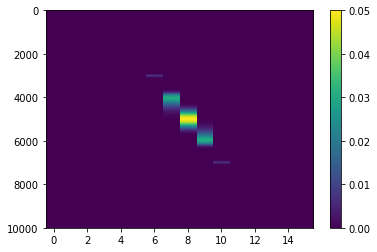

In [147]:
def time(freq, t_start, drift_rate):
    return t_start + drift_rate * freq

def freq(time, f_start, drift_rate):
    return f_start + drift_rate * time

def modulate(nus, bp=None):
    '''
    Modulate over frequencies, here's just an example, using gaussian envelop 
    try to mimick whatever variations/patterns seen in data'''
    length = nus.size
    df = nus[1] - nus[0]
#     fpeak = np.random.uniform(nus[500], nus[-500], size=1)
#     fwidth = np.random.uniform(length/20, length/5, size=1)*df
    fpeak = nu[length/2]
    fwidth = length/10*df
    if bp is None:
        return np.exp(-0.5 * (nus - fpeak) ** 2 / fwidth ** 2.)
    else:
        bpmod = np.where(bp>np.mean(bp), 1., bp/np.mean(bp))
        return np.exp(-0.5 * (nus - fpeak) ** 2 / fwidth ** 2.)*bpmod

t = np.arange(16)
nu = np.arange(0,10000)
t_0 = t[3]
t0_all = time(nu, t_0, 0.001)
modulation = modulate(nu)

# amp = np.random.uniform(0.05, 0.5) * modulate(nu)[:, np.newaxis]
#Note the values  1. is kind of arbitrary here, depending on how you normalize the background
# from the filterbank file. Make it around 5 times brighter than noise for start. . 
amp = 0.05 * modulate(nu)[:, np.newaxis]

# width = np.random.uniform(0.1, 0.5) * modulation[:, np.newaxis]
#also adjust these values to mimick data. 
width = 0.3 * modulation[:, np.newaxis]

print amp[np.argmax(modulation)], width[np.argmax(modulation)], t0_all[np.argmax(modulation)]
#!!! IMPORTANT: need to adjust numbers to make sure t0_all[np.argmax(modulation)] is roughly 
# inside t, else we won't see much pulse. 
pulse = amp * np.exp(-0.5 * (t - t0_all[:, np.newaxis]) ** 2 / width ** 2.)

# plt.figure(figsize=(15,10))
plt.imshow(pulse, 
           interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [149]:
t, t0_all[:, np.newaxis]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([[ 3.   ],
        [ 3.001],
        [ 3.002],
        ...,
        [12.997],
        [12.998],
        [12.999]]))

In [158]:
print(((t - t0_all[:, np.newaxis])**2).shape)
print(amp.shape)
print(width.shape)

(10000, 16)
(10000, 1)
(10000, 1)


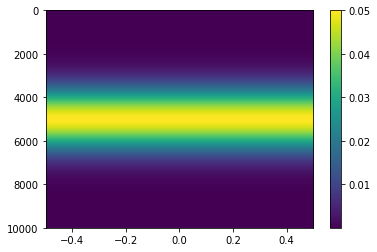

In [174]:
plt.imshow(amp, aspect='auto')
plt.colorbar()

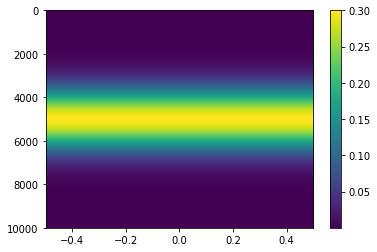

In [175]:
plt.imshow(width, aspect='auto')
plt.colorbar()

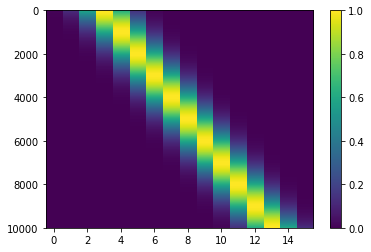

In [185]:
plt.imshow(np.exp(-0.5 * (t - t0_all[:, np.newaxis])**2.), aspect='auto')
plt.colorbar()

In [177]:
(amp), max(amp)

(array([[1.86332659e-07],
        [1.87266561e-07],
        [1.88204957e-07],
        ...,
        [1.89147865e-07],
        [1.88204957e-07],
        [1.87266561e-07]]), array([0.05]))

In [167]:
width, max(width)

(array([[1.11799595e-06],
        [1.12359937e-06],
        [1.12922974e-06],
        ...,
        [1.13488719e-06],
        [1.12922974e-06],
        [1.12359937e-06]]), array([0.3]))

In [170]:
pulse.shape

(10000, 16)

In [63]:
f_stop = fil.header['fch1']
df = fil.header['foff']
nchans = fil.header['nchans']
tsamp = fil.header['tsamp']

In [59]:
fil.header

{'az_start': 0.0,
 'data_type': 1,
 'fch1': 6095.214842353016,
 'foff': -2.7939677238464355e-06,
 'machine_id': 20,
 'nbits': 32,
 'nchans': 4194304,
 'nifs': 1,
 'source_name': 'HIP43223',
 'src_dej': <Angle 18.7477 deg>,
 'src_raj': <Angle 8.80492 hourangle>,
 'telescope_id': 6,
 'tsamp': 18.253611008,
 'tstart': 58090.468206018515,
 'za_start': 0.0}

In [70]:
nu = np.arange(f_stop, f_stop + nchans*df, df)
nu

array([6095.21484235, 6095.21483956, 6095.21483677, ..., 6083.49610073,
       6083.49609794, 6083.49609515])

In [65]:
t = np.arange(0, 16*tsamp, tsamp)
t

array([  0.        ,  18.25361101,  36.50722202,  54.76083302,
        73.01444403,  91.26805504, 109.52166605, 127.77527706,
       146.02888806, 164.28249907, 182.53611008, 200.78972109,
       219.0433321 , 237.2969431 , 255.55055411, 273.80416512])

In [104]:
t[::-1]

array([273.80416512, 255.55055411, 237.2969431 , 219.0433321 ,
       200.78972109, 182.53611008, 164.28249907, 146.02888806,
       127.77527706, 109.52166605,  91.26805504,  73.01444403,
        54.76083302,  36.50722202,  18.25361101,   0.        ])

In [69]:
fil.freqs

array([6095.21484235, 6095.21483956, 6095.21483677, ..., 6083.49610073,
       6083.49609794, 6083.49609515])

In [80]:
np.squeeze(fil.data)

array([[1.20499920e+08, 1.02085104e+08, 1.00356312e+08, ...,
        6.85245504e+08, 7.65114304e+08, 7.89899264e+08],
       [1.16726144e+08, 1.31366392e+08, 1.01820464e+08, ...,
        6.70228800e+08, 7.80599744e+08, 6.83070016e+08],
       [1.26294544e+08, 1.11825576e+08, 1.02323560e+08, ...,
        6.63051840e+08, 6.64867648e+08, 6.39698176e+08],
       ...,
       [1.50807648e+08, 1.17709800e+08, 1.22893696e+08, ...,
        6.49818176e+08, 8.48088960e+08, 7.80377536e+08],
       [1.11649736e+08, 1.00607560e+08, 1.02953864e+08, ...,
        6.69664768e+08, 7.71910464e+08, 6.29476416e+08],
       [1.44426480e+08, 8.69182960e+07, 1.20230336e+08, ...,
        8.12922112e+08, 5.67552000e+08, 7.62205824e+08]], dtype=float32)

In [96]:
fil_data

array([[ 0.9054248 ,  0.15703353, -1.2797099 , ..., -0.31775534,
        -0.2688674 , -0.12127165],
       [-0.06918249, -0.02318916,  1.2951632 , ..., -0.9990305 ,
        -1.4529659 , -0.04748832],
       [ 1.3984845 , -1.613789  ,  0.38672963, ..., -0.39626533,
         0.68490297, -2.3151743 ],
       ...,
       [-0.26436013, -0.04623459, -0.7594615 , ...,  0.2849724 ,
        -0.6523948 ,  2.1207995 ],
       [-1.772205  , -0.70917064, -0.518689  , ...,  2.497211  ,
         0.58780825,  1.02741   ],
       [ 0.750209  ,  0.43475178, -1.2847735 , ..., -0.6230802 ,
        -1.9228853 ,  0.45832807]], dtype=float32)

In [101]:
vars(fil)

{'beam_axis': 1,
 'container': <blimpy.file_wrapper.FIL_reader at 0x7f313e87d8d0>,
 'data': array([[[1.8482960e+10, 1.7536498e+10, 1.5259583e+10, ...,
          1.6622680e+10, 1.6724848e+10, 1.8161705e+10]],
 
        [[1.6916804e+10, 1.7282275e+10, 1.8433333e+10, ...,
          1.5167884e+10, 1.5181833e+10, 1.8267001e+10]],
 
        [[1.9275289e+10, 1.5038574e+10, 1.7313612e+10, ...,
          1.6455030e+10, 1.7967718e+10, 1.5030796e+10]],
 
        ...,
 
        [[1.6603161e+10, 1.7249767e+10, 1.5900834e+10, ...,
          1.7909746e+10, 1.6225068e+10, 2.1361355e+10]],
 
        [[1.4180111e+10, 1.6314629e+10, 1.6197606e+10, ...,
          2.2633763e+10, 1.7841193e+10, 1.9800984e+10]],
 
        [[1.8233534e+10, 1.7928247e+10, 1.5253342e+10, ...,
          1.5970689e+10, 1.4569475e+10, 1.8988849e+10]]], dtype=float32),
 'ext': 'fil',
 'file_header': {'az_start': 0.0,
  'data_type': 1,
  'fch1': 6095.214842353016,
  'foff': -2.7939677238464355e-06,
  'machine_id': 20,
  'nbits': 32,

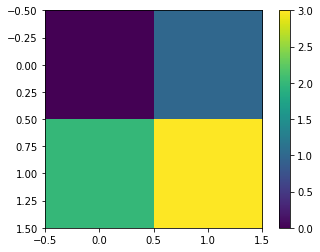

In [18]:
plt.imshow([[0,1],
            [2,3]])
plt.colorbar()

4194304
4194304


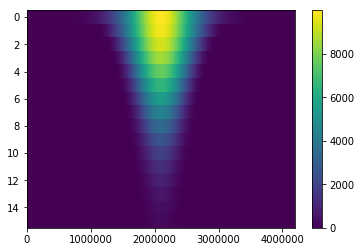

In [189]:
def time(freq, t_start, drift_rate):
    return t_start + drift_rate * freq

def freq(time, f_start, drift_rate):
    return f_start + drift_rate * time

def modulate(nus, bp=None):
    '''
    Modulate over frequencies, here's just an example, using gaussian envelop 
    try to mimick whatever variations/patterns seen in data'''
    length = nus.size
    print(length)
    df = nus[1] - nus[0]
#     fpeak = np.random.uniform(nus[500], nus[-500], size=1)
#     fwidth = np.random.uniform(length/20, length/5, size=1)*df
    fpeak = nu[length/2]
    fwidth = length/10*df
    if bp is None:
        return np.exp(-0.5 * (nus - fpeak) ** 2 / fwidth ** 2.)
    else:
        bpmod = np.where(bp>np.mean(bp), 1., bp/np.mean(bp))
        return np.exp(-0.5 * (nus - fpeak) ** 2 / fwidth ** 2.)*bpmod

nu = np.arange(f_stop, f_stop + nchans*df, df)
t = np.arange(0, 16*tsamp, tsamp)
nu_0 = nu[1000000]

nu_0_all = freq(t, nu_0, 1000)
modulation = modulate(nu)

# amp = np.random.uniform(0.05, 0.5) * modulate(nu)[:, np.newaxis]
#Note the values  1. is kind of arbitrary here, depending on how you normalize the background
# from the filterbank file. Make it around 5 times brighter than noise for start. . 
amp = 10000 * modulate(nu)[np.newaxis, :]

# width = np.random.uniform(0.1, 0.5) * modulation[:, np.newaxis]
#also adjust these values to mimick data. 
width = 100000 * modulation[np.newaxis, :]

#!!! IMPORTANT: need to adjust numbers to make sure t0_all[np.argmax(modulation)] is roughly 
# inside t, else we won't see much pulse. 
pulse = amp * np.exp(-0.5 * (nu - nu_0_all[:, np.newaxis]) ** 2 / width ** 2.)

# plt.figure(figsize=(15,10))
plt.imshow(pulse, 
           interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [115]:
pulse

array([[0., 0., 0., ..., 0., 0., 0.]])

In [116]:
nu_0_all

array([6101307.26322765, 6101307.26043368, 6101307.25763971, ...,
       6089588.52160955, 6089588.51881558, 6089588.51602161])

In [117]:
nu

array([6095.21484235, 6095.21483956, 6095.21483677, ..., 6083.49610073,
       6083.49609794, 6083.49609515])

In [119]:
modulation

array([3.72656432e-06, 3.72660875e-06, 3.72665317e-06, ...,
       3.72669760e-06, 3.72665317e-06, 3.72660875e-06])

In [212]:
def freq(time, f_start, drift_rate):
    return f_start + drift_rate * time
nu = np.arange(f_stop, f_stop + nchans*df, df)
t = np.arange(0, 16*tsamp, tsamp)
nu_0 = nu[1000000]

nu_0_all = freq(t, nu_0, -0.01)
nu_0_all

array([6092.42087463, 6092.23833852, 6092.05580241, 6091.8732663 ,
       6091.69073019, 6091.50819408, 6091.32565797, 6091.14312186,
       6090.96058575, 6090.77804964, 6090.59551353, 6090.41297742,
       6090.23044131, 6090.0479052 , 6089.86536909, 6089.68283298])

In [191]:
amp = nu_0_all[np.newaxis,:]
amp

array([[  6092.42087463,  24346.03188263,  42599.64289063,
         60853.25389863,  79106.86490663,  97360.47591463,
        115614.08692263, 133867.69793063, 152121.30893863,
        170374.91994663, 188628.53095463, 206882.14196263,
        225135.75297063, 243389.36397863, 261642.97498663,
        279896.58599463]])

In [192]:
width = nu_0_all[np.newaxis,:]
width

array([[  6092.42087463,  24346.03188263,  42599.64289063,
         60853.25389863,  79106.86490663,  97360.47591463,
        115614.08692263, 133867.69793063, 152121.30893863,
        170374.91994663, 188628.53095463, 206882.14196263,
        225135.75297063, 243389.36397863, 261642.97498663,
        279896.58599463]])

In [193]:
# pulse = amp * np.exp(-0.5 * (t - t0_all[:, np.newaxis]) ** 2 / width ** 2.)
t

array([  0.        ,  18.25361101,  36.50722202,  54.76083302,
        73.01444403,  91.26805504, 109.52166605, 127.77527706,
       146.02888806, 164.28249907, 182.53611008, 200.78972109,
       219.0433321 , 237.2969431 , 255.55055411, 273.80416512])

In [194]:
(nu - nu_0_all[:, np.newaxis]).shape

(16, 4194304)

In [197]:
(((nu - nu_0_all[:, np.newaxis]) == 0)).any()

True

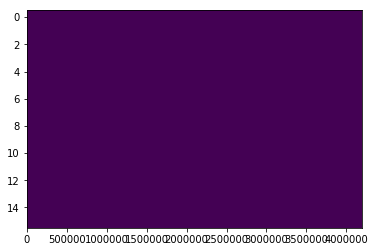

In [200]:
plt.imshow((nu - nu_0_all[:, np.newaxis]) == 0, aspect = 'auto')

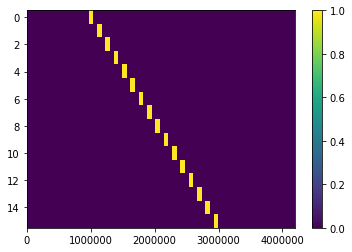

In [214]:
def freq(time, f_start, drift_rate):
    return f_start + drift_rate * time
nu = np.arange(f_stop, f_stop + nchans*df, df)
t = np.arange(0, 16*tsamp, tsamp)
nu_0 = nu[1000000]

nu_0_all = freq(t, nu_0, -0.02)
nu_0_all

def func(x):
    if np.abs(x) < 0.1:
        return 1
    else:
        return 0
    
vfunc = np.vectorize(func)
test = vfunc((nu - nu_0_all[:, np.newaxis]))
plt.imshow(test, aspect='auto')
plt.colorbar()

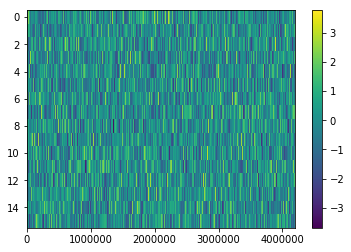

In [218]:
plt.imshow(fil_data, aspect='auto')
plt.colorbar()

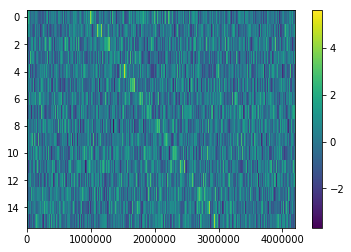

In [222]:
plt.imshow(fil_data + test * 2, aspect='auto')
plt.colorbar()

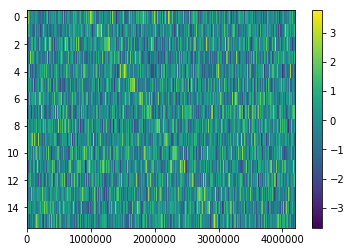

In [223]:
plt.imshow(normalize(fil_data + test * 2), aspect='auto')
plt.colorbar()

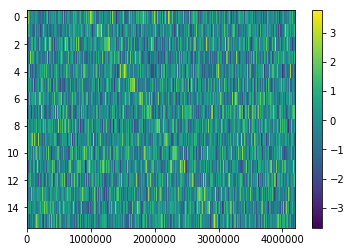

In [224]:
plt.imshow(normalize(normalize(fil_data + test * 2)), aspect='auto')
plt.colorbar()

In [19]:
import sys
import os
sys.path.append('../')

In [20]:
import setigen